# Utilities

In this lesson, we will explore useful utilities in TensorFlow + Keras like [Generators](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset), [Callbacks](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks), [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard), [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape), and hyperparameter tuning.

<a href="https://github.com/madewithml/practicalAI/blob/master/notebooks/basic_ml/08_Utilities.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/practicalAI/blob/master/notebooks/basic_ml/08_Utilities.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Overview

* **Generators**: generate batches of processed data
* **Callbacks**: Utility functions that are called at specific points during training/evaluation/inference. Very useful to customize the underlying operations during `model.fit()`.
* **TensorBoard**: tool to visualize metrics, weights, gradients, model architecture, hyperparameter optimization, etc.
* **GradientTape**: class that allows us to define operations for a highly customized training loop.
* **Hyperparameter tuning**: experimenting with different hyperparameter to see what combination yields the best validation performance.

# Data

## Load data

Let's download and process our non-linear spiral data for a classification task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [2]:
SEED = 1234
DATA_FILE = "spiral.csv"

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)

In [5]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/practicalAI/master/data/spiral.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

URLError: <urlopen error [Errno 61] Connection refused>

In [4]:
# Load data
df = pd.read_csv("spiral.csv", header=0)
X = df[['X1', 'X2']].values
y = df['color'].values
df.head(5)

,X1,X2,color
0,0.000000,0.000000,c1
1,-0.000457,0.001951,c1
2,0.001194,0.003826,c1
3,-0.000231,0.006008,c1
4,-0.000896,0.007966,c1


In [6]:
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


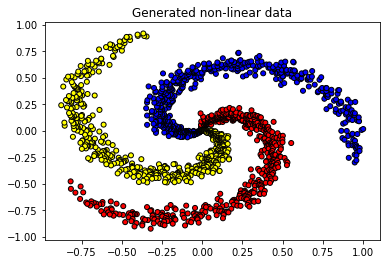

In [7]:
# Visualize data
plt.title("Generated non-linear data")
colors = {'c1': 'red', 'c2': 'yellow', 'c3': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()

## Split data

In [10]:
import collections
from sklearn.model_selection import train_test_split

In [12]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [13]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (1083, 2), y_train: (1083,)
X_val: (192, 2), y_val: (192,)
X_test: (225, 2), y_test: (225,)
Sample point: [ 0.23623443 -0.59618506] → c1
Classes: {'c1': 500, 'c3': 500, 'c2': 500}


## Label encoder

In [15]:
import json
from sklearn.preprocessing import LabelEncoder

In [16]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [17]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [18]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [43]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({0: 361, 2: 361, 1: 361}),
class weights: {0: 0.002770083102493075, 2: 0.002770083102493075, 1: 0.002770083102493075}


## Standardize data

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [21]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [22]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: 0.0, std: 1.0
X_train[1]: mean: 0.0, std: 1.0
X_val[0]: mean: 0.1, std: 1.0
X_val[1]: mean: 0.0, std: 1.0
X_test[0]: mean: 0.1, std: 1.0
X_test[1]: mean: -0.1, std: 0.9


# Generators

Generators will allow us to create batches for training, validation and testing. Generators become very useful when we want to apply batch-specific operations on our data.

In [21]:
# Use TensorFlow 2.x
%tensorflow_version 2.x


UsageError: Line magic function `%tensorflow_version` not found.


In [23]:
import tensorflow as tf

In [24]:
# Set seed for reproducability
tf.random.set_seed(SEED)

In [25]:
import math
from tensorflow.keras.utils import Sequence

In [26]:
BATCH_SIZE = 32

In [27]:
class DataGenerator(Sequence):
    """Custom data loader."""
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """# of batches."""
        return math.ceil(len(self.X) / self.batch_size)

    def __str__(self):
        return (f"<DataGenerator(" \
                f"batch_size={self.batch_size}, " \
                f"batches={len(self)}, " \
                f"shuffle={self.shuffle})>")

    def __getitem__(self, index):
        """Generate a batch."""
        # Gather indices for this batch
        batch_indices = self.epoch_indices[
            index * self.batch_size:(index+1)*self.batch_size]

        # Generate batch data
        X, y = self.create_batch(batch_indices=batch_indices)

        return X, y

    def on_epoch_end(self):
        """Create indices after each epoch."""
        self.epoch_indices = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.epoch_indices)

    def create_batch(self, batch_indices):
        """Generate batch from indices."""
        # Get batch data
        X = self.X[batch_indices]
        y = self.y[batch_indices]

        return X, y

In [28]:
# Dataset generator
training_generator = DataGenerator(X=X_train,
                                   y=y_train,
                                   batch_size=BATCH_SIZE,
                                   shuffle=SHUFFLE)
validation_generator = DataGenerator(X=X_val,
                                     y=y_val,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)
testing_generator = DataGenerator(X=X_test,
                                  y=y_test,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

In [29]:
print (f"training_generator: {training_generator}")
print (f"validation_generator: {validation_generator}")
print (f"testing_generator: {testing_generator}")

training_generator: <DataGenerator(batch_size=32, batches=34, shuffle=True)>
validation_generator: <DataGenerator(batch_size=32, batches=6, shuffle=False)>
testing_generator: <DataGenerator(batch_size=32, batches=8, shuffle=False)>


In [30]:
# Iterating through a generator
print (f"num test batches: {len(testing_generator)}")
for i, batch in enumerate(testing_generator):
    
    print (f"batch {i} | X: {batch[0].shape}, y: {batch[1].shape}")

num test batches: 8
batch 0 | X: (32, 2), y: (32,)
batch 1 | X: (32, 2), y: (32,)
batch 2 | X: (32, 2), y: (32,)
batch 3 | X: (32, 2), y: (32,)
batch 4 | X: (32, 2), y: (32,)
batch 5 | X: (32, 2), y: (32,)
batch 6 | X: (32, 2), y: (32,)
batch 7 | X: (1, 2), y: (1,)


In [31]:
print (f"num test batches: {len(validation_generator)}")
for i, batch in enumerate(validation_generator):
    
    print (f"batch {i} | X: {batch[0].shape}, y: {batch[1].shape}")

num test batches: 6
batch 0 | X: (32, 2), y: (32,)
batch 1 | X: (32, 2), y: (32,)
batch 2 | X: (32, 2), y: (32,)
batch 3 | X: (32, 2), y: (32,)
batch 4 | X: (32, 2), y: (32,)
batch 5 | X: (32, 2), y: (32,)


## Model

In [32]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [33]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
DROPOUT_P = 0.1
NUM_CLASSES = len(classes)
LEARNING_RATE = 1e-2

In [34]:
X_train.shape

(1083, 2)

In [35]:
class MLP(Model):
    def __init__(self, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__(name='mlp_with_dropout')
        self.fc1 = Dense(units=hidden_dim, activation='relu', 
                         kernel_initializer=glorot_normal(),
                         name='W1')
        self.dropout = Dropout(rate=dropout_p, name='dropout')
        self.fc2 = Dense(units=num_classes, activation='softmax', name='W2')
        
    def call(self, x_in, training=False):
        z = self.fc1(x_in)
        z = self.dropout(z, training=training)
        y_pred = self.fc2(z)
        return y_pred
    
    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        summary.summary() # parameter summary
        print ("\n\nWEIGHTS:") # weights summary
        for layer in self.layers:
            print ("_"*50)
            print (layer.name)
            for w in layer.weights:
                print (f"\t{w.name} → {w.shape}")
        print ("\n\nFORWARD PASS:")
        return plot_model(summary, show_shapes=True) # forward pass

In [36]:
# Initialize model
model = MLP(hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)

In [37]:
# Summary
model.summary(input_shape=(INPUT_DIM,))

Model: "mlp_with_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 2)]               0         
_________________________________________________________________
W1 (Dense)                   (None, 100)               300       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
W2 (Dense)                   (None, 3)                 303       
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


WEIGHTS:
__________________________________________________
W1
	W1/kernel:0 → (2, 100)
	W1/bias:0 → (100,)
__________________________________________________
dropout
__________________________________________________
W2
	W2/kernel:0 → (100, 3)
	W2/

In [38]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

# Callbacks

Callbacks are a great way to customize your training, evaluation and inference loops by defining operations to occur at certain points. View the full list of available callbacks in the [official documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks). We will also be implementing a custom callback in the next section.

We'll be using the following callbacks in the examples below:

* [EarlyStopping](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping): early stopping criteria will monitor a metric and stop training early if performance degrades for a certain number of epochs (patience). 

* [ModelCheckpoint](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/ModelCheckpoint): model checkpoint will save a model to a file path based on monitoring a metric.

* [ReduceLROnPlateau](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau): reduce the learning rate when a monitored metric stops improving for a certain number of epochs (patience).

* [TensorBoard](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/TensorBoard): visualize metrics, weight values and histograms (we'll use this in the tensorboard section)

In [39]:
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

In [40]:
EARLY_STOPPING_CRITERIA = 3
MODEL_FILE = 'model.hdf5'
NUM_EPOCHS = 10

In [41]:
# Define callbacks
run_dir = 'tensorboard/callback_run'
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=EARLY_STOPPING_CRITERIA, verbose=0),
             ModelCheckpoint(filepath=MODEL_FILE, monitor='val_loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True),
             ReduceLROnPlateau(monitor='val_loss', mode='min', patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir=run_dir, histogram_freq=1, update_freq='epoch')] # TensorBoard Callback

* [EarlyStopping](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping): we'll monitoring the validation loss (`monitor='val_loss'`) and we'll stop the training process easy when the minimum (`mode='min'`) validation loss stop improving for `EARLY_STOPPING_CRITERIA` epochs in a row (`patience=EARLY_STOPPING_CRITERIA`).

* [ModelCheckpoint](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/ModelCheckpoint): we'll save the best (`save_best_only=True`) model's weights (`save_weights_only=True`) based on the minimum (`mode='min'`) validation loss (`monitor='val_loss'`) to the file path `MODEL_FILE` (`filepath=MODEL_FILE`).

* [ReduceLROnPlateau](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau): we'll reduce the learning rate by a factor of 0.1 (`factor=0.1`) when the validation loss (`monitor='val_loss'`) doesn't decrease (`mode='min'`) for more than 1 epoch (`patience=1`).

* [TensorBoard](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/TensorBoard): we'll save metrics every epoch (`update_freq='epoch'`) to the `run_dir` (`log_dir=run_dir`).


In [44]:
# Training
model.fit(x=training_generator,
          epochs=NUM_EPOCHS,
          validation_data=validation_generator,
          shuffle=False,
          class_weight=class_weights,
          verbose=1,
          callbacks=callbacks) # add callbacks

  ...
    to  
  ['...']
Train for 34 steps, validate for 6 steps
Epoch 1/10
34/34 [==============================] - 1s 23ms/step - loss: 0.0020 - sparse_categorical_accuracy: 0.5697 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 0.6667
Epoch 2/10
34/34 [==============================] - 0s 7ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 0.8385
Epoch 3/10
34/34 [==============================] - 0s 7ms/step - loss: 8.9016e-04 - sparse_categorical_accuracy: 0.8957 - val_loss: 7.7756e-04 - val_sparse_categorical_accuracy: 0.9271
Epoch 4/10
34/34 [==============================] - 0s 7ms/step - loss: 5.8853e-04 - sparse_categorical_accuracy: 0.9455 - val_loss: 5.5944e-04 - val_sparse_categorical_accuracy: 0.9479
Epoch 5/10
34/34 [==============================] - 0s 5ms/step - loss: 4.4347e-04 - sparse_categorical_accuracy: 0.9575 - val_loss: 4.2903e-04 - val_sparse_categorical_accuracy: 0.9531
Epoch 6/10
34/34 [=

In [45]:
# The best model has been saved to the directory
!ls 

02_NumPy.ipynb
03_Pandas-checkpoint.ipynb
04_Linear_Regression.ipynb
05_Logistic_Regression.ipynb
05_PT_Utilities.ipynb
06_Multilayer_Perceptrons.ipynb
07_Data_and_Models.ipynb
08_Utilities.ipynb
datasets
dentalFormulas.txt
model.hdf5
model.pth
spiral.csv
tensorboard
tumors.csv
tumors_reduced.csv
机器学习（无监督类）案例.ipynb


In [46]:
# Visualize performance on tensorboard
%tensorboard --logdir tensorboard

You can see the `ReduceLROnPlateau` callback reduced the learning rate as our training progressed.

# Custom callbacks

In [47]:
from tensorflow.keras.callbacks import Callback
from tensorflow.summary import create_file_writer
from tensorflow.summary import text

We could add any of the following [methods](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/Callback#methods) to our custom callback at key points during<br> training, testing, and prediction allowing for powerful customization while leveraging fit functions.

<table align="left">
        <tr>
            <th>
                <b>General</b>
            </th>
            <th>
                <b>Training</b>
            </th>
            <th>
                <b>Evaluation</b>
            </th>
            <th>
                <b>Inference</b>
            </th>
        </tr>
        <tr>
            <td>on_batch_begin</td>
            <td>on_train_batch_begin</td>
            <td>on_test_batch_begin</td>
            <td>on_predict_batch_begin</td>
        </tr>
        <tr>
            <td>on_batch_end</td>
            <td>on_train_batch_end</td>
            <td>on_test_batch_end</td>
            <td>on_predict_batch_end</td>
        </tr>
        <tr>
            <td>on_epoch_begin</td>
            <td>on_train_begin</td>
            <td>on_test_begin</td>
            <td>on_predict_begin</td>
        </tr>
         <tr>
            <td>on_epoch_end</td>
            <td>on_train_end</td>
            <td>on_test_end</td>
            <td>on_predict_end</td>
        </tr>
    </table>

Our custom callback will be predict the class for center of our spiral `(0.0, 0.0)` and we will do this at the end of every training epoch (`on_epoch_end`).

In [48]:
class PredictCenterPoint(Callback):
    def __init__(self, classes, file_writer):
        self.center_point = np.array([[0.0, 0.0]])
        self.classes = classes
        self.file_writer = file_writer
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        z = self.model(self.center_point).numpy()
        prediction = self.classes[np.argmax(z, axis=1)[0]]
        self.history.append(prediction)
        print (f"(0.0, 0.0) → {prediction}")

        # Log to TensorBoard
        with self.file_writer.as_default():
            text('center_point_class', data=prediction, step=epoch)

**NOTE**: We can write many other types of data, besides text, to tensorboard as well. You find learn about them [here](https://www.tensorflow.org/api_docs/python/tf/summary).

In [49]:
# Define callbacks
run_dir = 'tensorboard/custom_callback_run'
file_writer = create_file_writer(run_dir) # to store custom metrics on tensorboard
predict_center_point = PredictCenterPoint(classes=classes, file_writer=file_writer)
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=EARLY_STOPPING_CRITERIA, verbose=0),
             ModelCheckpoint(filepath=MODEL_FILE, monitor='val_loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True),
             ReduceLROnPlateau(monitor='val_loss', mode='min', patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir=run_dir, histogram_freq=1, update_freq='epoch'),
             predict_center_point] # TensorBoard Callback

In [50]:
# Initialize model
model = MLP(hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [51]:
# Training
model.fit(x=training_generator,
          epochs=NUM_EPOCHS,
          validation_data=validation_generator,
          shuffle=False,
          class_weight=class_weights,
          verbose=2, # verbose=2 doesn't use the progress bar
          callbacks=callbacks) # add callbacks

  ...
    to  
  ['...']
Train for 34 steps, validate for 6 steps
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(0.0, 0.0) → c3
34/34 - 1s - loss: 0.0021 - sparse_categorical_accuracy: 0.5512 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/10
(0.0, 0.0) → c3
34/34 - 0s - loss: 0.0015 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 0.8438
Epoch 3/10
(0.0, 0.0) → c2
34/34 - 0s - loss: 9.8046e-04 - sparse_categorical_accuracy: 0.8827 - val_loss: 8.7768e-04 - val_sparse_categor

In [52]:
# Custom callback results
predict_center_point.history

['c3', 'c3', 'c2', 'c2', 'c2', 'c3', 'c2', 'c3', 'c3', 'c3']

In [53]:
# Visualize performance on tensorboard (click on the TEXT tab to see our center point predictions)
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 4529), started 0:00:34 ago. (Use '!kill 4529' to kill it.)

# GradientTape

So far we've used `model.fit` to train our models. This has been very useful so we don't have to write training loop biolerplate code every time while still giving us enough control via callbacks, loss, metrics, etc. But what if we wanted even more control in customizing our training loop? Tensorflow's [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) allows us to do exactly this.

In [54]:
from tensorflow.keras.metrics import Mean

In [55]:
# Initialize model
model = MLP(hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)

In [56]:
# Compile
optimizer = Adam(lr=LEARNING_RATE)
loss_fn = SparseCategoricalCrossentropy()

In [57]:
# Metrics
train_loss = Mean(name='train_loss')
val_loss = Mean(name='val_loss')
train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = SparseCategoricalAccuracy(name='val_accuracy')

In [58]:
# Train step
@tf.function
def train_step(x, y):

    # Forward pass and loss
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_fn(y, y_pred)

    # Backprop
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Metrics
    train_loss(loss)
    train_accuracy(y, y_pred)

In [59]:
# Validation step
@tf.function
def val_step(x, y):
    # Forward pass and loss
    y_pred = model(x)
    loss = loss_fn(y, y_pred)

    # Metrics
    val_loss(loss)
    val_accuracy(y, y_pred)

In [60]:
# Training
for epoch in range(NUM_EPOCHS):

    # Reset metrics for new epoch
    model.reset_metrics()
    
    # Training
    for batch in training_generator:
        X, y = batch
        train_step(X, y)

    # Validation
    for batch in validation_generator:
        X, y = batch
        val_step(X, y)

    # Metrics
    print (f"Epoch: {epoch} | train_loss: {train_loss.result():.2f} | train_acc: {train_accuracy.result(): .2f} | val_loss: {val_loss.result():.2f} | val_acc: {val_accuracy.result(): .2f}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0 | train_loss: 0.71 | train_acc:  0.57 | val_loss: 0.61 | val_acc:  0.70
Epoch: 1 | train_loss: 0.59 | train_acc:  0.67 | val_loss: 0.51 | val_acc:  0.77
Epoch: 2 | train_loss: 0.49 | train_acc:  0.76 | val_loss: 0.43 | val_acc:  0.83
Epoch: 3 | train_loss: 0.42 | train_acc:  0.81 | val_loss: 0.37 | val_acc:  0.86
Epoch: 4 | train_loss: 0.36 | train_acc:  0.84 | val_loss: 0.33 | val_acc:  0.88
Epoch: 5 | train_loss: 0.32 | train_acc:  0.86 | val_loss: 0.30 | val_acc:  0.90
Epoch: 6 | train_loss:

# Hyperparameter Optimization

How do we know that the parameters (like *HIDDEN_DIM*, *DROPOUT_P*, *LEARNING_RATE*, etc.) we chose for our model are the best? We can empirically validate by doing hyperparameter optimization with TensorBoard. We will just try a few hyperparameter values but you can see the results and fine tune ever more.

In [61]:
from tensorboard.plugins.hparams import api as hp

In [62]:
def train_test_model(hparams):
    """Training and testing functions.
    """
    # Initialize
    model = MLP(hidden_dim=hparams[HP_HIDDEN_DIM],
            dropout_p=hparams[HP_DROPOUT_P],
            num_classes=NUM_CLASSES)

    # Compile
    model.compile(optimizer=Adam(lr=hparams[HP_LR]),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=[SparseCategoricalAccuracy()])
    
    # Callbacks
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=EARLY_STOPPING_CRITERIA, verbose=0),
                 ReduceLROnPlateau(monitor='val_loss', mode='min', patience=1, factor=0.1, verbose=0)]
    
    # Training
    model.fit(x=training_generator,
              epochs=NUM_EPOCHS,
              validation_data=validation_generator,
              class_weight=class_weights,
              callbacks=callbacks,
              shuffle=False,
              verbose=1)

    # Evaluate
    test_loss, test_accuracy = model.evaluate(x=testing_generator, verbose=1)
    
    return test_accuracy

In [63]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        # Record hparams in this run
        hp.hparams(hparams) 
        accuracy = train_test_model(hparams)
        tf.summary.scalar('accuracy', accuracy, step=1)

In [64]:
# Hyperparameters
HP_HIDDEN_DIM = hp.HParam('hidden_dim', hp.Discrete([16, 32]))
HP_DROPOUT_P = hp.HParam('dropout_p', hp.RealInterval(0.1, 0.2))
HP_LR = hp.HParam('lr', hp.Discrete([1e-3, 1e-2]))

In [65]:
log_dir = 'tensorboard/hparam_tuning'
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_HIDDEN_DIM, HP_HIDDEN_DIM, HP_LR],
        metrics=[hp.Metric('accuracy', display_name='Accuracy')],
        )

In [66]:
session_num = 0
for hidden_dim in HP_HIDDEN_DIM.domain.values:
    for dropout_p in (HP_DROPOUT_P.domain.min_value, HP_DROPOUT_P.domain.max_value):
        for lr in HP_LR.domain.values:
            hparams = {
                HP_HIDDEN_DIM: hidden_dim,
                HP_DROPOUT_P: dropout_p,
                HP_LR: lr,
            }
            run_name = f"run-{session_num:04d}"
            print(f"--- Starting trial: {run_name}")
            print({h.name: hparams[h] for h in hparams})
            run(f'{log_dir}/' + run_name, hparams)
            session_num += 1


--- Starting trial: run-0000
{'hidden_dim': 16, 'dropout_p': 0.1, 'lr': 0.001}
  ...
    to  
  ['...']
Train for 34 steps, validate for 6 steps
Epoch 1/10
34/34 [==============================] - 1s 21ms/step - loss: 0.0035 - sparse_categorical_accuracy: 0.2493 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.3125
Epoch 2/10
34/34 [==============================] - 0s 6ms/step - loss: 0.0032 - sparse_categorical_accuracy: 0.3167 - val_loss: 0.0031 - val_sparse_categorical_accuracy: 0.3021
Epoch 3/10
34/34 [==============================] - 0s 4ms/step - loss: 0.0030 - sparse_categorical_accuracy: 0.3804 - val_loss: 0.0030 - val_sparse_categorical_accuracy: 0.4167
Epoch 4/10
34/34 [==============================] - 0s 4ms/step - loss: 0.0029 - sparse_categorical_accuracy: 0.4211 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 0.4635
Epoch 5/10
34/34 [==============================] - 0s 4ms/step - loss: 0.0027 - sparse_categorical_accuracy: 0.4894 - val_loss: 0.0027 - val_

34/34 [==============================] - 0s 4ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 0.7812
Epoch 10/10
34/34 [==============================] - 0s 4ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.7738 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 0.7812
  ...
    to  
  ['...']
8/8 [==============================] - 0s 10ms/step - loss: 0.3969 - sparse_categorical_accuracy: 0.8489
--- Starting trial: run-0004
{'hidden_dim': 32, 'dropout_p': 0.1, 'lr': 0.001}
  ...
    to  
  ['...']
Train for 34 steps, validate for 6 steps
Epoch 1/10
34/34 [==============================] - 1s 16ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.1958 - val_loss: 0.0031 - val_sparse_categorical_accuracy: 0.2292
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 0.0030 - sparse_categorical_accuracy: 0.3158 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 0.4323
Epoch 3/10
34/34 [====

34/34 [==============================] - 0s 5ms/step - loss: 9.9945e-04 - sparse_categorical_accuracy: 0.8735 - val_loss: 9.0820e-04 - val_sparse_categorical_accuracy: 0.8906
Epoch 7/10
34/34 [==============================] - 0s 4ms/step - loss: 9.6021e-04 - sparse_categorical_accuracy: 0.8717 - val_loss: 8.3889e-04 - val_sparse_categorical_accuracy: 0.9115
Epoch 8/10
34/34 [==============================] - 0s 4ms/step - loss: 8.2967e-04 - sparse_categorical_accuracy: 0.9040 - val_loss: 8.2097e-04 - val_sparse_categorical_accuracy: 0.8906
Epoch 9/10
34/34 [==============================] - 0s 4ms/step - loss: 8.6325e-04 - sparse_categorical_accuracy: 0.8873 - val_loss: 8.2082e-04 - val_sparse_categorical_accuracy: 0.8906
Epoch 10/10
34/34 [==============================] - 0s 3ms/step - loss: 8.0316e-04 - sparse_categorical_accuracy: 0.9132 - val_loss: 8.2075e-04 - val_sparse_categorical_accuracy: 0.8906
  ...
    to  
  ['...']
8/8 [==============================] - 0s 9ms/step - lo

In [67]:
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 4529), started 0:01:21 ago. (Use '!kill 4529' to kill it.)

**NOTE**: We will explore even more TensorBoard features in subsequent lessons, such as  visualzing imaging datasets, embeddings, and many more! 

---
Share and discover ML projects at <a href="https://madewithml.com/#newsletter">Made With ML</a>.

<a class="ai-header-badge" target="_blank" href="https://github.com/practicalAI/practicalAI"><img src="https://img.shields.io/github/stars/practicalAI/practicalAI.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
             